<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Orthogonal Random Forest and Causal Forest: Use Cases and Examples

Causal Forests and Generalized Random Forests are a flexible method for estimating treatment effect heterogeneity with Random Forests. Orthogonal Random Forest (ORF) combines orthogonalization, a technique that effectively removes the confounding effect in two-stage estimation, with generalized random forests. Due to the orthogonalization aspect of this method, the ORF performs especially well in the presence of high-dimensional confounders. For more details, see [this paper](https://arxiv.org/abs/1806.03467) or the [EconML docummentation](https://econml.azurewebsites.net/).

The EconML SDK implements the following OrthoForest variants:

* DMLOrthoForest: suitable for continuous or discrete treatments

* DROrthoForest: suitable for discrete treatments

* CausalForest: suitable for both discrete and continuous treatments

In this notebook, we show the performance of the ORF on synthetic and observational data. 

## Notebook Contents

1. [Example Usage with Continuous Treatment Synthetic Data](#1.-Example-Usage-with-Continuous-Treatment-Synthetic-Data)
2. [Example Usage with Binary Treatment Synthetic Data](#2.-Example-Usage-with-Binary-Treatment-Synthetic-Data)
3. [Example Usage with Multiple Treatment Synthetic Data](#3.-Example-Usage-with-Multiple-Treatment-Synthetic-Data)
4. [Example Usage with Real Continuous Treatment Observational Data](#4.-Example-Usage-with-Real-Continuous-Treatment-Observational-Data)

In [7]:
# Main imports
! pip install econml
from econml.orf import DMLOrthoForest, DROrthoForest
from econml.dml import CausalForestDML
from econml.sklearn_extensions.linear_model import WeightedLassoCVWrapper, WeightedLasso

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import Lasso, LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [8]:
# Treatment effect function
def exp_te(x):
    return np.exp(2*x[0])

In [11]:
# DGP constants
np.random.seed(123)
n = 1000
n_w = 30
support_size = 5
n_x = 1
# Outcome support
support_Y = np.random.choice(range(n_w), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
def epsilon_sample(n):
    return np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
def eta_sample(n):
    return np.random.uniform(-1, 1, size=n)

# Generate controls, covariates, treatments and outcomes
W = np.random.normal(0, 1, size=(n, n_w))
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = np.array([exp_te(x_i) for x_i in X])
T = np.dot(W[:, support_T], coefs_T) + eta_sample(n)
Y = TE * T + np.dot(W[:, support_Y], coefs_Y) + epsilon_sample(n)

# ORF parameters and test data
subsample_ratio = 0.3
lambda_reg = np.sqrt(np.log(n_w) / (10 * subsample_ratio * n))
X_test = np.array(list(product(np.arange(0, 1, 0.01), repeat=n_x)))

## 1.2. Train Estimator

**Note:** The models in the final stage of the estimation (``model_T_final``, ``model_Y_final``) need to support sample weighting. 

If the models of choice do not support sample weights (e.g. ``sklearn.linear_model.LassoCV``), the ``econml`` packages provides a convenient wrapper for these models ``WeightedModelWrapper`` in order to allow sample weights.

In [12]:
est = DMLOrthoForest(
    n_trees=1000, min_leaf_size=5,
    max_depth=50, subsample_ratio=subsample_ratio,
    model_T=Lasso(alpha=lambda_reg),
    model_Y=Lasso(alpha=lambda_reg),
    model_T_final=WeightedLasso(alpha=lambda_reg),
    model_Y_final=WeightedLasso(alpha=lambda_reg),
    global_residualization=False,
    random_state=123)

To use the built-in confidence intervals constructed via Bootstrap of Little Bags, we can specify `inference="blb"` at `fit` time or leave the default `inference='auto'` which will automatically use the Bootstrap of Little Bags.

In [13]:
from sklearn.model_selection import train_test_split
df = pd.read_stata('school_intervention_panel_final.dta', convert_categoricals=False)
follow_up_1_df = df[df['round'] == 0]
follow_up_2_df = df[df['round'] == 1]

categ = ['dumm_rp_23_bl', 'dumm_rp_59_bl', 'dumm_rp_50_bl', 'dumm_rp_55_bl',
         'dumm_rp88__92AB_bl', 
        'dumm_rp88__92C_fup', 'dumm_rp_56_bl', 'dumm_search_bl', 
         'dumm_rp_14p_bl', 'dumm_rp88__92D_bl', 'treatment', 'dumm_rp88__92C_fup']

df_cleaned = follow_up_2_df.dropna(subset=categ)

df_train, df_test = train_test_split(df_cleaned, test_size=0.2, random_state=123)

X = df_train[['dumm_rp_23_bl', 'dumm_rp_59_bl', 'dumm_rp_50_bl', 'dumm_rp_55_bl', 'dumm_rp88__92AB_bl']].values  
T = df_train[['treatment']].values  
Y = df_train[['dumm_rp88__92C_fup']].values.ravel()
W = df_train[['dumm_rp88__92C_fup', 'dumm_rp_56_bl', 'dumm_search_bl', 'dumm_rp_14p_bl', 'dumm_rp88__92D_bl']].values

print(Y.shape, T.shape, X.shape, W.shape)
est.fit(Y, T, X=X, W=W, inference="blb")


One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.


(6948,) (6948, 1) (6948, 5) (6948, 5)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
Objective did n

In [14]:
# Calculate treatment effects
X_test = df_test[['dumm_rp_23_bl', 'dumm_rp_59_bl', 'dumm_rp_50_bl', 'dumm_rp_55_bl', 'dumm_rp88__92AB_bl']].values  
treatment_effects = est.effect(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 368 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 1008 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 1738 out of 1738 | elapsed:   25.0s finished


In [15]:
# Calculate default (95%) confidence intervals for the test data
te_lower, te_upper = est.effect_interval(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 1738 out of 1738 | elapsed:   47.1s finished


In [16]:
res = est.effect_inference(X_test)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 232 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 1000 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:   43.3s
[Parallel(n_jobs=-1)]: Done 1738 out of 1738 | elapsed:   47.2s finished


In [17]:
res.summary_frame().head()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,-0.010,0.013,-0.749,0.454,-0.035,0.016
1,-0.002,0.017,-0.117,0.907,-0.034,0.030
2,-0.001,0.008,-0.141,0.888,-0.017,0.015
3,0.001,0.009,0.058,0.954,-0.018,0.019
4,-0.001,0.008,-0.141,0.888,-0.017,0.015


In [18]:
res.population_summary()

In [26]:
print(dir(est))

['T_one', 'T_two', 'W_one', 'W_two', 'X_one', 'X_two', 'Y_one', 'Y_two', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_combine', '_d_t', '_d_t_in', '_d_y', '_defer_to_inference', '_expand_treatments', '_fit_forest', '_gen_allowed_missing_vars', '_get_blb_indices', '_get_inference', '_get_inference_options', '_get_weights', '_inference', '_input_names', '_input_names_set', '_model_T', '_model_T_final', '_model_Y', '_model_Y_final', '_original_treatment_featurizer', '_postfit', '_predict', '_prefit', '_pw_effect_inputs', '_set_input_names', '_set_transformed_treatment_names', '_strata', '_use_inference_method', '_wrap_fit', 'allow_missing', '

In [31]:
print(est.forest_one_trees[0])

In [33]:
print(dir(est.forest_one_trees[0]))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slotnames__', '__str__', '__subclasshook__', '__weakref__', 'balancedness_tol', 'create_splits', 'find_split', 'max_depth', 'min_leaf_size', 'n_proposals', 'print_tree', 'print_tree_rec', 'random_state', 'tree']


Similarly we can estimate effects and get confidence intervals and inference results using a `CausalForest`.

In [20]:
est2 = CausalForestDML(model_t=Lasso(alpha=lambda_reg),
                       model_y=Lasso(alpha=lambda_reg),
                       n_estimators=4000, min_samples_leaf=5,
                       max_depth=50,
                       verbose=0, random_state=123)
est2.tune(Y, T, X=X, W=W)
est2.fit(Y, T, X=X, W=W)
treatment_effects2 = est2.effect(X_test)
te_lower2, te_upper2 = est2.effect_interval(X_test, alpha=0.01)

In [45]:
res = est2.const_marginal_effect_inference(X_test)
point = res.point_estimate
lb, ub = res.conf_int(alpha=.01)

In [49]:
est2.feature_importances_

array([0.32847544, 0.16391506, 0.18411805, 0.15112518, 0.17236628])

In [65]:
res.summary_frame().head()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,-0.004,0.004,-1.091,0.275,-0.012,0.004
1,0.001,0.003,0.247,0.805,-0.006,0.007
2,-0.003,0.003,-1.074,0.283,-0.009,0.003
3,-0.003,0.004,-0.907,0.364,-0.011,0.004
4,-0.003,0.003,-1.074,0.283,-0.009,0.003


## 1.3. Performance Visualization

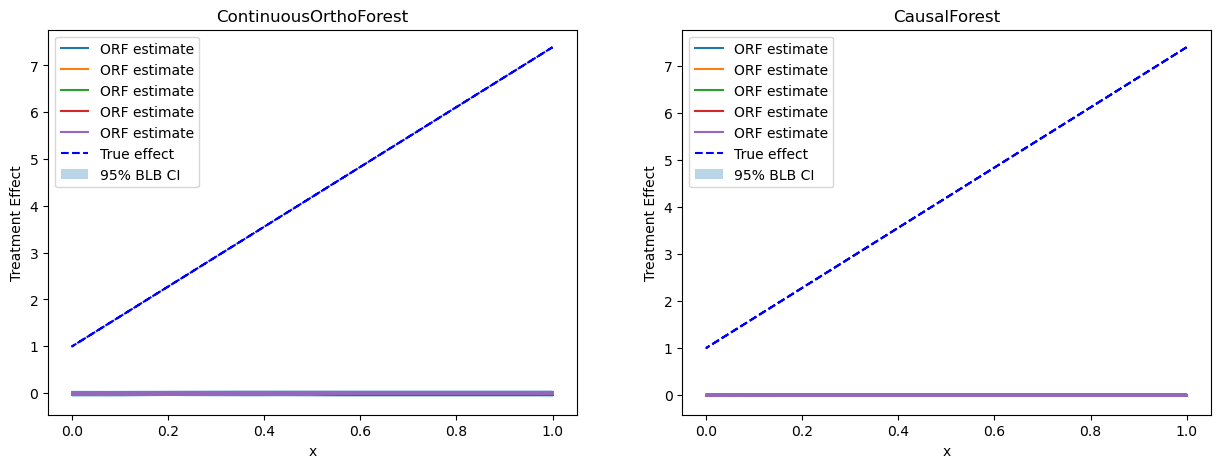

In [21]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("ContinuousOrthoForest")
plt.plot(X_test, treatment_effects, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower, te_upper, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.subplot(1, 2, 2)

plt.title("CausalForest")
plt.plot(X_test, treatment_effects2, label='ORF estimate')
expected_te = np.array([exp_te(x_i) for x_i in X_test])
plt.plot(X_test[:, 0], expected_te, 'b--', label='True effect')
plt.fill_between(X_test[:, 0], te_lower2, te_upper2, label="95% BLB CI", alpha=0.3)
plt.ylabel("Treatment Effect")
plt.xlabel("x")
plt.legend()
plt.show()